# Squared-root Kalman filter for online learning

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree
import flax.linen as nn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

In [3]:
sns.set_palette("colorblind")
palette = sns.color_palette()

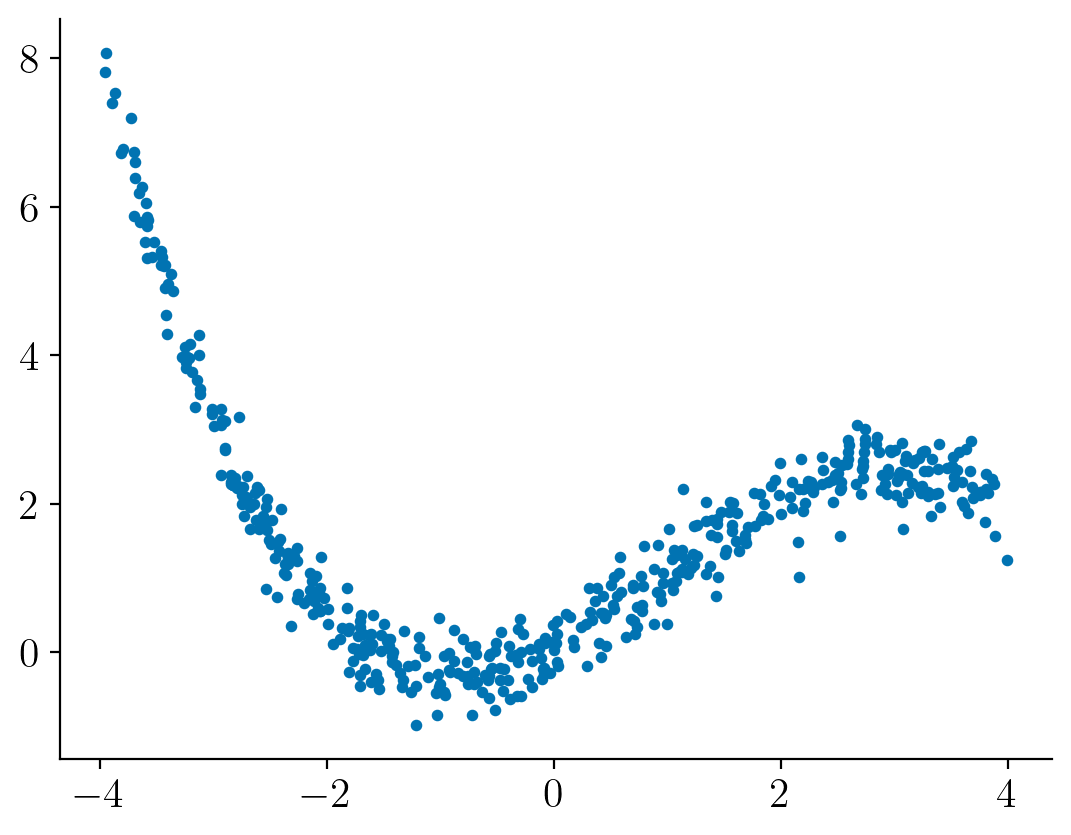

In [4]:
key = jax.random.PRNGKey(314)
key_data, key_filter = jax.random.split(key)
key_x, key_y, key_coef, key_samples = jax.random.split(key_data, 4)
m = 1
n_test = 200
n_samples = 300 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8, 0.3, -0.1])
xmin, xmax = -4, 4
X = jax.random.uniform(key_x, (n_samples, m)) * (xmax - xmin) + xmin
Phi = jnp.c_[X ** 0, X ** 1, X ** 2, X** 3]

errs = jax.random.normal(key_y, (n_samples,)) * 0.3
y = jnp.einsum("sm,m->s", Phi, coefs) + errs
y = jnp.atleast_2d(y).T
plt.scatter(X, y, s=10)

## Kalman filter

### Predict step
$$
\begin{aligned}
    \mu_{t|t-1} &= {\bf F}_t\,\mu_{t-1}\\
    \Sigma_{t|t-1} &= {\bf F}_t\,\Sigma_{t-1}\,{\bf F}_t^\intercal + Q_t
\end{aligned}
$$

### Innovation and Gain
$$
\begin{aligned}
    \hat y_t &= {\bf H}_t\,\mu_{t|t-1}\\
    {\bf S}_t &= {\bf H}_t\,\Sigma_{t|t-1}\,{\bf H}_t^\intercal + R_t\\
    {\bf K}_t &= \Sigma_{t|t-1}\,{\bf H}_t^\intercal\,{\bf S}_t^{-1}
\end{aligned}
$$


### Predict
$$
\begin{aligned}
\mu_t &= \mu_{t|t-1} + {\bf K}_t(y_t - \hat{y}_t)\\
\Sigma_t &= \Sigma_{t|t-1} - {\bf K}_t\,{\bf S}_t\,{\bf K}_t^\intercal
\end{aligned}
$$

In [5]:
_, D = Phi.shape
mu_init = jnp.zeros(D)
Sigma_init = jnp.eye(D)

In [6]:
Rt = 0.3 ** 2 * jnp.eye(1)
Qt = jnp.eye(D) * 0.0

In [7]:
def step(state, obs):
    mu, Sigma = state
    X, y = obs
    X = X[:, None]

    Sigma = Sigma + Qt

    yhat = X.T @ mu
    St = X.T  @ Sigma @ X + Rt
    Kt = jnp.linalg.solve(St, X.T @ Sigma).T

    mu = mu + Kt @ (y - yhat)
    Sigma = Sigma - Kt @ St @ Kt.T
    return (mu, Sigma), yhat

In [8]:
dataset = (Phi, y)
bel_init = (mu_init, Sigma_init)
(mu_final, Sigma_final), yhat_hist = jax.lax.scan(step, bel_init, dataset)

In [9]:
yhat_final = jnp.einsum("sm,m->s", Phi, mu_final)

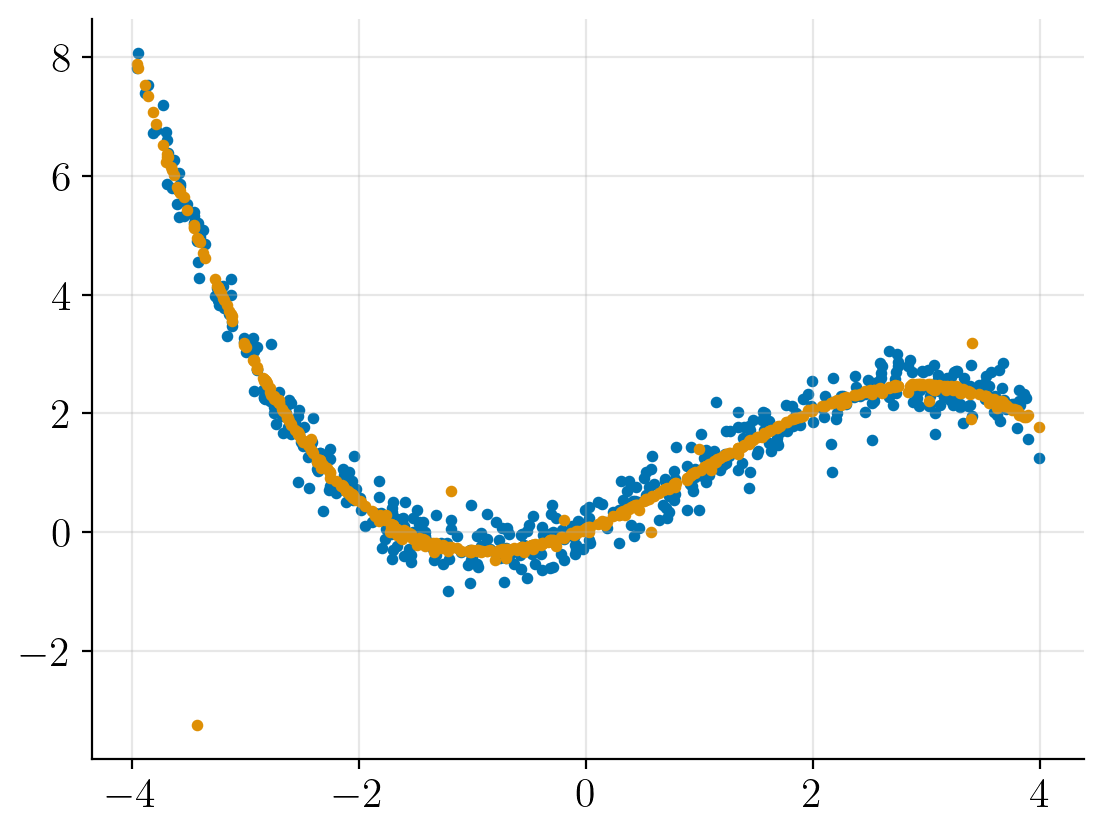

In [10]:
plt.scatter(X, y, s=10)
plt.scatter(X, yhat_hist, s=10)
plt.grid(alpha=0.3)

## Squared-root Kalman filter

In [11]:
xt = Phi[-1, None]

In [12]:
W_final = jnp.linalg.cholesky(Sigma_final, upper=True)

In [13]:
W_final.T @ W_final

Array([[ 4.16736439e-04,  1.46283555e-05, -4.59825242e-05,
        -9.27299254e-07],
       [ 1.46283555e-05,  2.25199037e-04,  1.92730042e-07,
        -2.09871450e-05],
       [-4.59825242e-05,  1.92730042e-07,  8.97261089e-06,
        -1.34723734e-07],
       [-9.27299254e-07, -2.09871450e-05, -1.34723734e-07,
         2.31828517e-06]], dtype=float32)

In [14]:
Sigma_final

Array([[ 4.1673641e-04,  1.4627870e-05, -4.5980192e-05, -9.2969560e-07],
       [ 1.4628839e-05,  2.2519904e-04,  1.9606145e-07, -2.0986210e-05],
       [-4.5984860e-05,  1.8939849e-07,  8.9726109e-06, -1.3971501e-07],
       [-9.2490279e-07, -2.0988080e-05, -1.2973246e-07,  2.3182852e-06]],      dtype=float32)

### Innovation

$$
\begin{aligned}
    S_t
    &= H_t\Sigma_{t|t-1}H_t^\intercal + R_t\\
    &= H_t W_{t|t-1}^\intercal W_{t|t-1} H_t^\intercal + R_t^{\intercal/2}\,R_t^{1/2}\\
    &=
    \begin{bmatrix}
        H_t W_{t|t-1}^\intercal & R_t^{\intercal/2}
    \end{bmatrix}
    \begin{bmatrix}
    W_{t|t-1}H_t^\intercal\\
    R_t^{1/2}
    \end{bmatrix}
\end{aligned}
$$

In [15]:
Rt_half = jnp.linalg.cholesky(Rt, upper=True)

In [16]:
W_final @ Phi[-1, None].T

Array([[-0.01190468],
       [-0.01806444],
       [ 0.02656864],
       [ 0.0329905 ]], dtype=float32)

In [17]:
part = jnp.r_[W_final @ xt.T, Rt_half]
S_half = jnp.linalg.qr(part, mode="r") # Squared-root of innovation
S_half @ S_half.T

Array([[0.09226231]], dtype=float32)

In [18]:
S = Phi[-1].T @ Sigma_final @ Phi[-1] + Rt
S

Array([[0.09226231]], dtype=float32)

### Kalman gain

$$
\begin{aligned}
    K_t
    &= \Sigma_{t|t-1}\,H_t^\intercal\,S_t^{-1}\\
    &= \left(S_t^{-1}\,H_t\Sigma_{t|t-1}\right)^\intercal\\
    &= \left(S_t^{-1/2}S_t^{-\intercal/2}\,H_t\,W_{t|t-1}^\intercal W_{t|t-1}\right)^\intercal
\end{aligned}
$$

In [19]:
Sigma_final @ xt.T @ jnp.linalg.inv(S) # Kalman gain-full

Array([[-0.00263513],
       [-0.00302624],
       [ 0.00083146],
       [ 0.00048509]], dtype=float32)

In [20]:
Kt = jnp.linalg.solve(S_half, jnp.linalg.solve(S_half.T, xt) @ W_final.T @ W_final).T
Kt

Array([[-0.00263405],
       [-0.00302732],
       [ 0.00083459],
       [ 0.00048432]], dtype=float32)

### Update

$$
\begin{aligned}
\Sigma_t
&= \Sigma_{t|t-1} - {\bf K}_t\,{\bf S}_t\,{\bf K}_t^\intercal\\
&= W_{t|t-1}^\intercal\,W_{t|t-1} - {\bf K}_t\,{\bf S}_t^{\intercal/2}\,{\bf S}_t^{1/2}\,{\bf K}_t^\intercal\\
&=
\begin{bmatrix}W_{t|t-1}^\intercal &  {\bf K}_t\,{\bf S}_t^{\intercal/2}\end{bmatrix}
\begin{bmatrix}W_{t|t-1} \\ {\bf S}_t^{1/2}\,{\bf K}_t^\intercal\end{bmatrix}
\end{aligned}
$$

In [21]:
part = jnp.r_[W_final, 1j * S_half @ Kt.T]
W_update = jnp.linalg.qr(part, mode="r").real
W_update

Array([[-2.0429796e-02, -7.5204199e-04,  2.2606857e-03,  5.1150852e-05],
       [ 0.0000000e+00, -1.5015959e-02, -1.1053259e-04,  1.4041032e-03],
       [ 0.0000000e+00,  0.0000000e+00, -1.9783727e-03,  2.9249761e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -6.0411089e-04]],      dtype=float32)

In [22]:
W_update.T @ W_update

Array([[ 4.1737655e-04,  1.5364065e-05, -4.6185345e-05, -1.0450015e-06],
       [ 1.5364065e-05,  2.2604459e-04, -4.0377731e-08, -2.1122423e-05],
       [-4.6185345e-05, -4.0377731e-08,  9.0368749e-06, -9.7430096e-08],
       [-1.0450015e-06, -2.1122423e-05, -9.7430096e-08,  2.3399280e-06]],      dtype=float32)

In [23]:
Sigma_final - Kt @ S @ Kt.T

Array([[ 4.1609627e-04,  1.3892160e-05, -4.5777368e-05, -8.1199340e-07],
       [ 1.3893129e-05,  2.2435348e-04,  4.2916943e-07, -2.0850934e-05],
       [-4.5782035e-05,  4.2250645e-07,  8.9083460e-06, -1.7700867e-07],
       [-8.0720059e-07, -2.0852804e-05, -1.6702612e-07,  2.2966431e-06]],      dtype=float32)

### Implementation

In [24]:
Rt = 0.3 ** 2 * jnp.eye(1)
Rt_half = jnp.linalg.cholesky(Rt, upper=True)

In [25]:
def step(state, obs):
    mu, W = state
    X, y = obs
    I = jnp.eye(len(X))
    
    X = X[:, None]

    # Predict
    yhat = X.T @ mu

    # Innovation update
    part = jnp.r_[W @ X, Rt_half]
    S_half = jnp.linalg.qr(part, mode="r") # Squared-root of innovation

    # Kalman gain
    Kt = jnp.linalg.solve(S_half, jnp.linalg.solve(S_half.T, X.T) @ W.T @ W).T

    # Upate
    mu = mu + Kt @ (y - yhat)
    part = jnp.r_[W @ (I - Kt @ X.T).T, Rt_half @ Kt.T]
    W = jnp.linalg.qr(part, mode="r").real

    return (mu, W), yhat

In [26]:
_, D = Phi.shape
mu_init = jnp.zeros(D)
W_init = jnp.linalg.cholesky(jnp.eye(D))

In [27]:
dataset = (Phi, y)
bel_init = (mu_init, W_init)
(mu_final_sqr, W_final), yhat_hist = jax.lax.scan(step, bel_init, dataset)

In [28]:
W_final

Array([[ 2.0414250e-02,  7.1636128e-04, -2.2524821e-03, -4.5343113e-05],
       [ 0.0000000e+00,  1.4989391e-02,  1.2010184e-04, -1.3979992e-03],
       [ 0.0000000e+00,  0.0000000e+00,  1.9711757e-03, -3.4700941e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  6.0052960e-04]],      dtype=float32)

In [29]:
yhat_final = jnp.einsum("sm,m->s", Phi, mu_final)

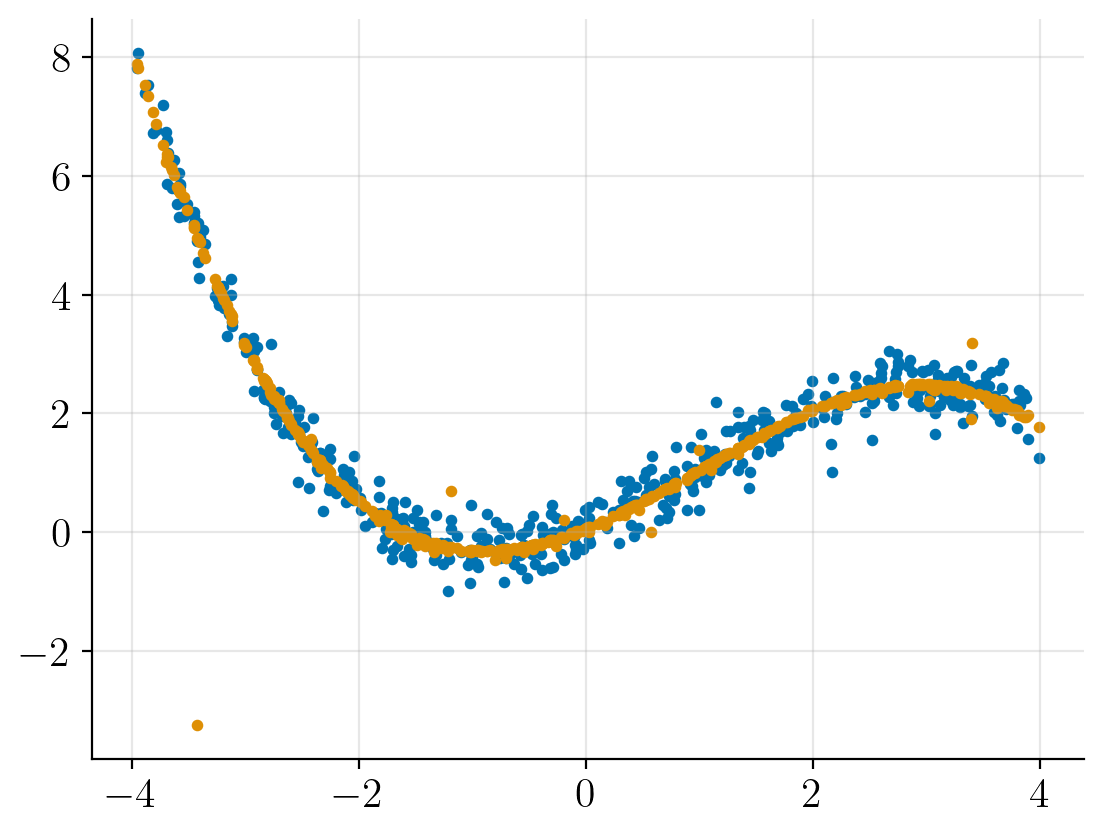

In [30]:
plt.scatter(X, y, s=10)
plt.scatter(X, yhat_hist, s=10)
plt.grid(alpha=0.3)

## Comparing full and squared-root

## mean

In [31]:
mu_final

Array([ 0.07861608,  0.77277946,  0.30483395, -0.09767698], dtype=float32)

In [32]:
mu_final_sqr

Array([ 0.07861531,  0.7727789 ,  0.30482748, -0.09767526], dtype=float32)

### Covariance

In [33]:
Sigma_final

Array([[ 4.1673641e-04,  1.4627870e-05, -4.5980192e-05, -9.2969560e-07],
       [ 1.4628839e-05,  2.2519904e-04,  1.9606145e-07, -2.0986210e-05],
       [-4.5984860e-05,  1.8939849e-07,  8.9726109e-06, -1.3971501e-07],
       [-9.2490279e-07, -2.0988080e-05, -1.2973246e-07,  2.3182852e-06]],      dtype=float32)

In [34]:
W_final.T @ W_final

Array([[ 4.1674159e-04,  1.4623978e-05, -4.5982732e-05, -9.2564562e-07],
       [ 1.4623978e-05,  2.2519502e-04,  1.8666248e-07, -2.0987640e-05],
       [-4.5982732e-05,  1.8666248e-07,  8.9736341e-06, -1.3416938e-07],
       [-9.2564562e-07, -2.0987640e-05, -1.3416938e-07,  2.3182979e-06]],      dtype=float32)

## References

* Tracy, Kevin. "A square-root kalman filter using only qr decompositions." arXiv preprint arXiv:2208.06452 (2022).